# Лабораторная работа №1. Классификация

**Тема:** *Сравнение логистической регрессии, случайного леса (Random Forest Classifier), градиентного бустинга (XGBoost) на задаче регрессии.*

**Цели:**

- *Научиться строить, оптимизировать и оценивать регрессионные модели.*
- *Понять, как интерпретировать важность признаков (feature importance).*
- *Понять, как увеличивать кол-во признаков (feature tuning).*
- *Исследовать влияние преобразований признаков (фичей), регуляризации и гиперпараметров.*

**Условия:**

- *numpy, pandas, scikit-learn, XGBoost*
- *выбрать датасет для 1-ой и 2-ой лабораторной работы*

**Пункты:**

1. Подготовка данных + Feature Tuning
2. Создание метрик
3. Базовая модель линейной регрессии
4. Улучшение линейной регрессии
5. Случайный лес регрессор
6. Градиентный бустинг (XGBoost)
7. Feature Importance
8. Написание своих реализаций (классы)
9. Подведение итогов


## О команде (ЗАПОЛНИТЬ СВОИМИ ДАННЫМИ)

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Горбан А.В.         | 307    | Solo way       | Все сам                      |

 Датасет: [Titanic-Dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset)

## Описание датасета

Этот набор данных связан с пасажирами Титаника. Набор данных описывает характеристики пассажиров, и выжили ли они после караблекрушения. Наша задача — предсказать выживание с помощью предоставленных данных.

Простой, но сложный проект по прогнозированию выживания.
Сложность возникает из-за того, что набор данных содержит меньше образцов и является сильно несбалансированным.

---

### Таблица признаков

| №  | Признак                  | Тип данных     | Описание                                                           |
| -- | ------------------------ | -------------- | ------------------------------------------------------------------ |
| 1  | **PassengerId**          | integer        | Passenger ID                                                       |
| 2  | **Survived**             | integer (0–1)  | Weather Survived or not: 0 = No, 1 = Yes                           |
| 3  | **Pclass**               | integer        | Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd                            |
| 4  | **Name**                 | string         | Name of the Passenger                                              |
| 5  | **Sex**                  | string         | Gender                                                             |
| 6  | **Age**                  | integer        | Age in Years                                                       |
| 7  | **SibSp**                | integer        | No. of siblings / spouses aboard the Titanic                       |
| 8  | **Parch**                | integer        | No. of parents / children aboard the Titanic                       |
| 9  | **Ticket**               | string         | Ticket number                                                      |
| 10 | **Fare**                 | float          | Passenger fare                                                     |
| 11 | **Cabin**                | string         | Cabin number                                                       |
| 12 | **Embarked**             | string         | Port of Embarkation:C = Cherbourg, Q = Queenstown, S = Southampton |


## 0. Глобальная настройка проекта


In [656]:
RND_SEED = 21
USE_AUTO_POLY = True

## 1. Подготовка данных + Feature Tuning

### 1.1. Загрузка датасета

Подключим `файл на моем компьютере` и загрузим наш датасет используя `Pandas.DataFrame`

Подключение к файлу

In [657]:
import pandas as pd
import numpy as np
from pathlib import Path

file_path = Path('Titanic-Dataset.csv')
df = pd.read_csv(file_path)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Получение статистки по датасету, необходимую для анализа.

У нас тут имеется ненужный атрибут `PassengerID`. Можем его удалить.
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

In [658]:
if 'PassengerId' in df.columns:
    df = df.drop(columns=['PassengerId'])
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 1.1,5 Форматирование текстовых данных

#### 1. Кодирование категориальных признаков

In [659]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

df['Deck'] = df['Cabin'].str[0]
deck_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}
df['Deck'] = df['Deck'].map(deck_mapping)

df['Cabin'] = df['Cabin'].str.extract(r'(\d+)')
df['Cabin'] = pd.to_numeric(df['Cabin'], errors='coerce')

df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.0,NaN
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,85.0,1.0,2.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,NaN


#### 2. Обработка пропусков


In [660]:
df['Age'] = df['Age'].fillna(df['Age'].median())

df['Embarked'] = df['Embarked'].fillna(0)

df['Deck'] = df['Deck'].fillna(-1)

df['Cabin'] = df['Cabin'].fillna(-1)
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,-1.0,0.0,-1.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,85.0,1.0,2.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,-1.0,0.0,-1.0


#### 3. Удаление ненужных колонок


In [661]:
df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True, errors='ignore')
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Deck
0,0,3,0,22.0,1,0,7.2500,-1.0,0.0,-1.0
1,1,1,1,38.0,1,0,71.2833,85.0,1.0,2.0
2,1,3,1,26.0,0,0,7.9250,-1.0,0.0,-1.0


### 1.2. Сбор основной информации

Получение общей информации `df.info()`

In [662]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    float64
 8   Embarked  891 non-null    float64
 9   Deck      891 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 69.7 KB


Получение всей статистики `df.describe()`

In [663]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Deck
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.361582,0.523008,0.381594,32.204208,10.557800,0.361392,-0.223345
std,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,27.242766,0.635673,1.590899
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,-1.000000,0.000000,-1.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,-1.000000,0.000000,-1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,-1.000000,1.000000,-1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,148.000000,2.000000,7.000000


**Вывод:**

1. Общая информация

    * **Размер датасета**: 891 наблюдение.
    * **Целевая переменная (survived)**: среднее ≈ **0.38**.
    
        -> Значит, выжило только около 38% пассажиров.
    
        -> ДИСБАЛАНС КЛАССОВ - большинство пассажиров не выжило.

2. Социально-экономический статус

    * **Pclass**:

        * Медиана = 3, среднее ≈ 2.3.
        * Большинство пассажиров путешествовали третьим классом.
        * Вероятно, сильная корреляция с выживаемостью.

3. Возрастная структура

    * **Age**:

        * Среднее ≈ 29.7 лет, медиана = 28 лет.
        * Есть пропуски (только 714 значений из 891).
        * Диапазон от 0.42 до 80 лет → на борту были младенцы и пожилые люди.
        * 25% пассажиров младше 20 лет, 75% младше 38 лет.

4. Семейные связи

    * **SibSp**:

        * Медиана = 0, среднее ≈ 0.52.

        -> Большинство пассажиров путешествовали без родственников.

        * Максимум 8 → есть очень большие семьи.

    * **Parch**:

        * Медиана = 0, среднее ≈ 0.38.

        -> Большинство пассажиров путешествовали без детей/родителей.

5. Экономические показатели

    * **Fare**:

        * Медиана = 14.45, среднее ≈ 32.20.

        * Сильный разброс (от 0 до 512.33) → большой разброс в благосостоянии.

        * 75% пассажиров заплатили ≤ 31, но есть экстремально дорогие билеты.

6. кабины

    * **Cabin**:

        * 75% пассажиров не имели информацию об их кабине

Проверка на пропуски данных `df.isnull().sum()`

In [664]:
print(df.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
Deck        0
dtype: int64


**Вывод:** в датасете нет пропусков!

Посмотрим на распределение целевой переменной

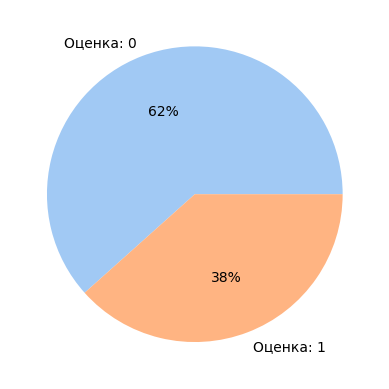

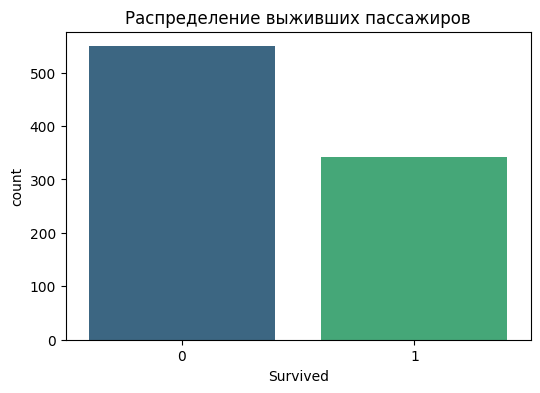

In [665]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_pie_plot(df: pd.DataFrame, column_name: str):
    explore_column = df[column_name]
    explore_column_normal = list(zip(
        [f'Оценка: {q}' for q in explore_column.value_counts().index],
        explore_column.value_counts(normalize=True)
    ))

    label, params = zip(*explore_column_normal)

    colors = sns.color_palette('pastel')[0:len(params)]
    plt.pie(params, labels=label, colors=colors, autopct='%.0f%%')
    plt.show()

def draw_bar_plot(df: pd.DataFrame, column_name: str, title: str):
    plt.figure(figsize=(6,4))
    sns.countplot(x=column_name, data=df, hue="Survived", palette="viridis", legend=False)
    plt.title(title)
    plt.show()


draw_pie_plot(df, 'Survived')
draw_bar_plot(df, 'Survived', title = "Распределение выживших пассажиров")

**Вывод:** целевая переменная является сильно несбалансирована

Посмотрим на корреляцию данных.

***Определение 1: Корреляция данных — это статистическая мера, показывающая, насколько и в каком направлении связаны между собой две переменные.***

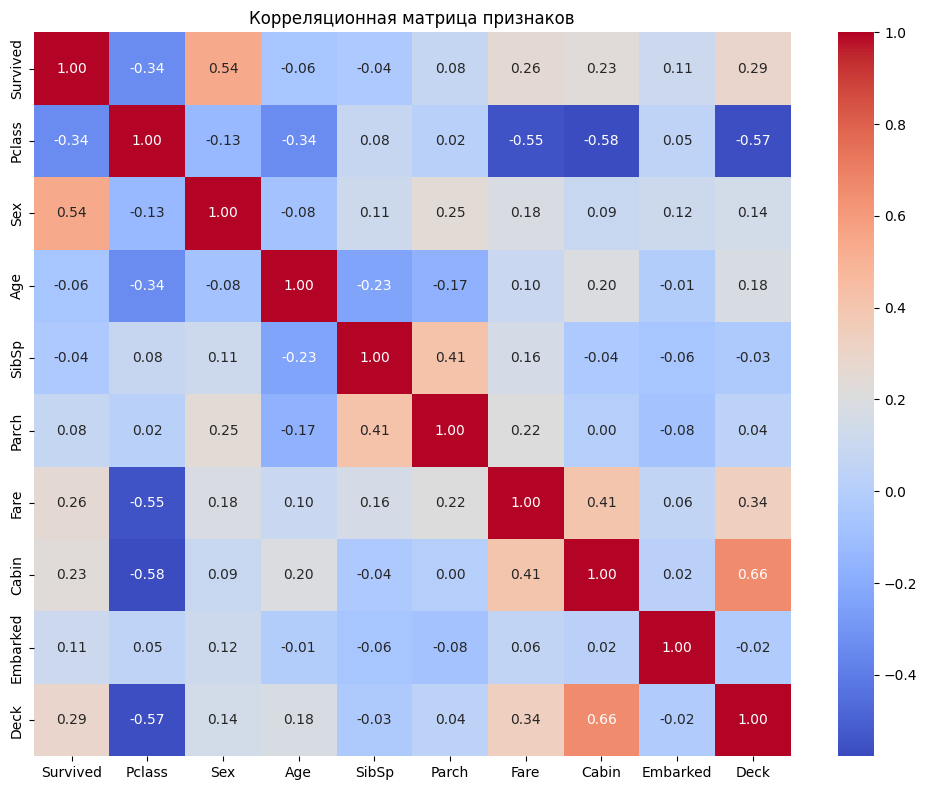

In [666]:
def draw_corr_matrix(df):
    numeric_df = df.select_dtypes(include=['number'])
    
    plt.figure(figsize=(10,8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляционная матрица признаков")
    plt.tight_layout()
    plt.show()

draw_corr_matrix(df)

### 1.3. Подготовка датасета под разные задачи

Cравнение подготовки для задачи классификации

| Модель                  | Масштабирование | Корреляция критична | Выбросы критичны | Feature Engineering рекомендуем                  |
| ----------------------- | --------------- | ------------------- | ---------------- | ------------------------------------------------ |
| Логистическая регрессия | Да              | Да                  | Да               | Биннинг, отношения, кодирование категорий        |
| Random Forest Classifier| Нет             | Нет                 | Нет              | Кодирование категорий, создание новых признаков  |
| XGBoost Classifier      | Нет             | Нет                 | Нет              | Кодирование категорий, отношения, интеракции     |

#### 1.3.1 Логистическая регрессия (Logistic Regression)

**Особенности модели:**

- Чувствительна к масштабу признаков и мультиколлинеарности
- Чувствительна к выбросам.
- Предсказывает вероятность (0% - 100%)

Сделаем копию датасета

In [667]:
df_linear = df.copy()

Рассмотрим скошенность данных

***Определение 2: Скошенность – это мера асимметрии распределения признака***

* **Скошенность > 0 (положительная):** Хвост распределения тянется вправо (большие значения встречаются реже).

* **Скошенность < 0 (отрицательная):** Хвост распределения тянется влево (малые значения редки).

* **Скошенность ≈ 0:** Практически нормальное распределение (симметричное).


In [668]:
skew_values = df_linear.skew()
skew_values_hard = skew_values[abs(skew_values) > 0.5]  # выделяем сильноскошенные данные
print(skew_values_hard)  # сильно скошенные

skew_columns_hard = list(skew_values_hard.index)
print(f'Скошенные столбцы {skew_columns_hard}')

Pclass     -0.630548
Sex         0.618921
Age         0.510245
SibSp       3.695352
Parch       2.749117
Fare        4.787317
Cabin       2.609125
Embarked    1.543397
Deck        1.991925
dtype: float64
Скошенные столбцы ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Deck']


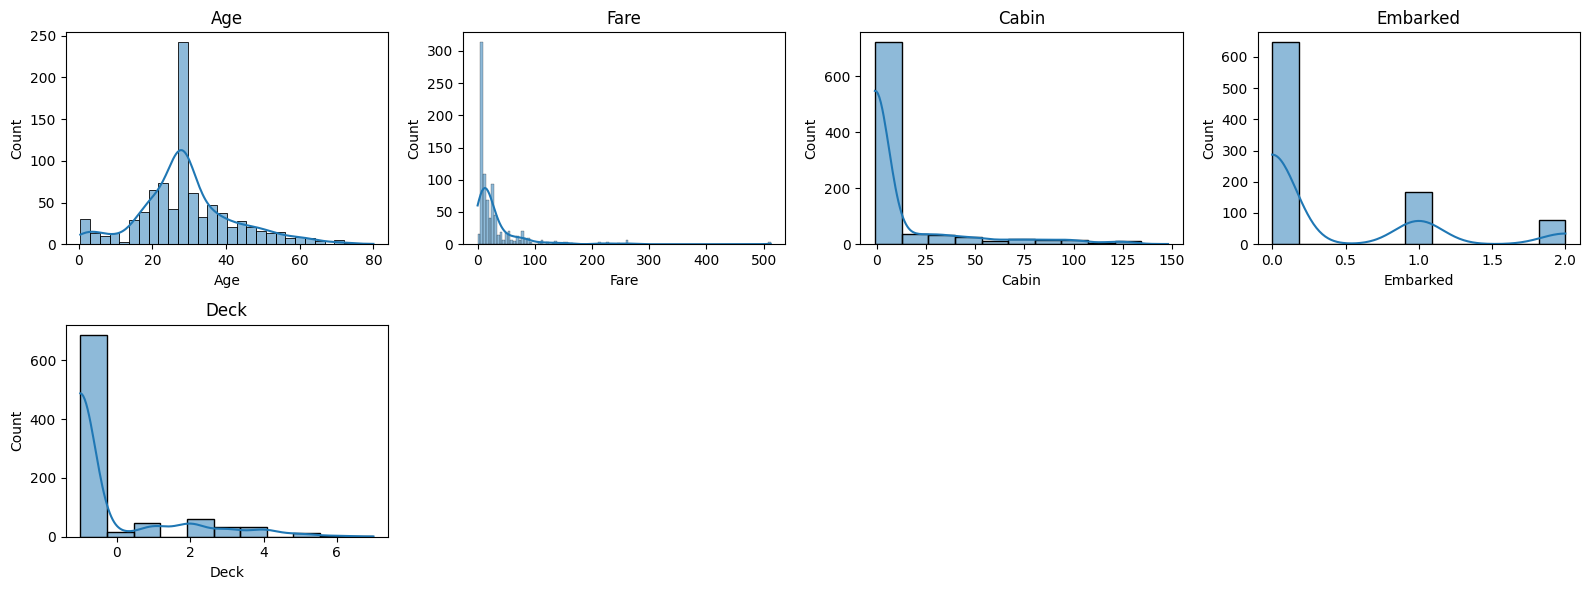

In [669]:
import math

def draw_skew(df: pd.DataFrame, n_cols=4):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()


draw_skew(df_linear)

Можно уменьшить влияние скошенности с помошью:

- Логарифмирование (Уменьшаем положительный хвост)
- Квадратный корень  (сглаживаем умеренные хвосты)
- `Box-Cox` или `Yeo-Johnson` трансформации (более гибкие)

Мы же просто прологарифмируем :)

c:\Users\arty\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


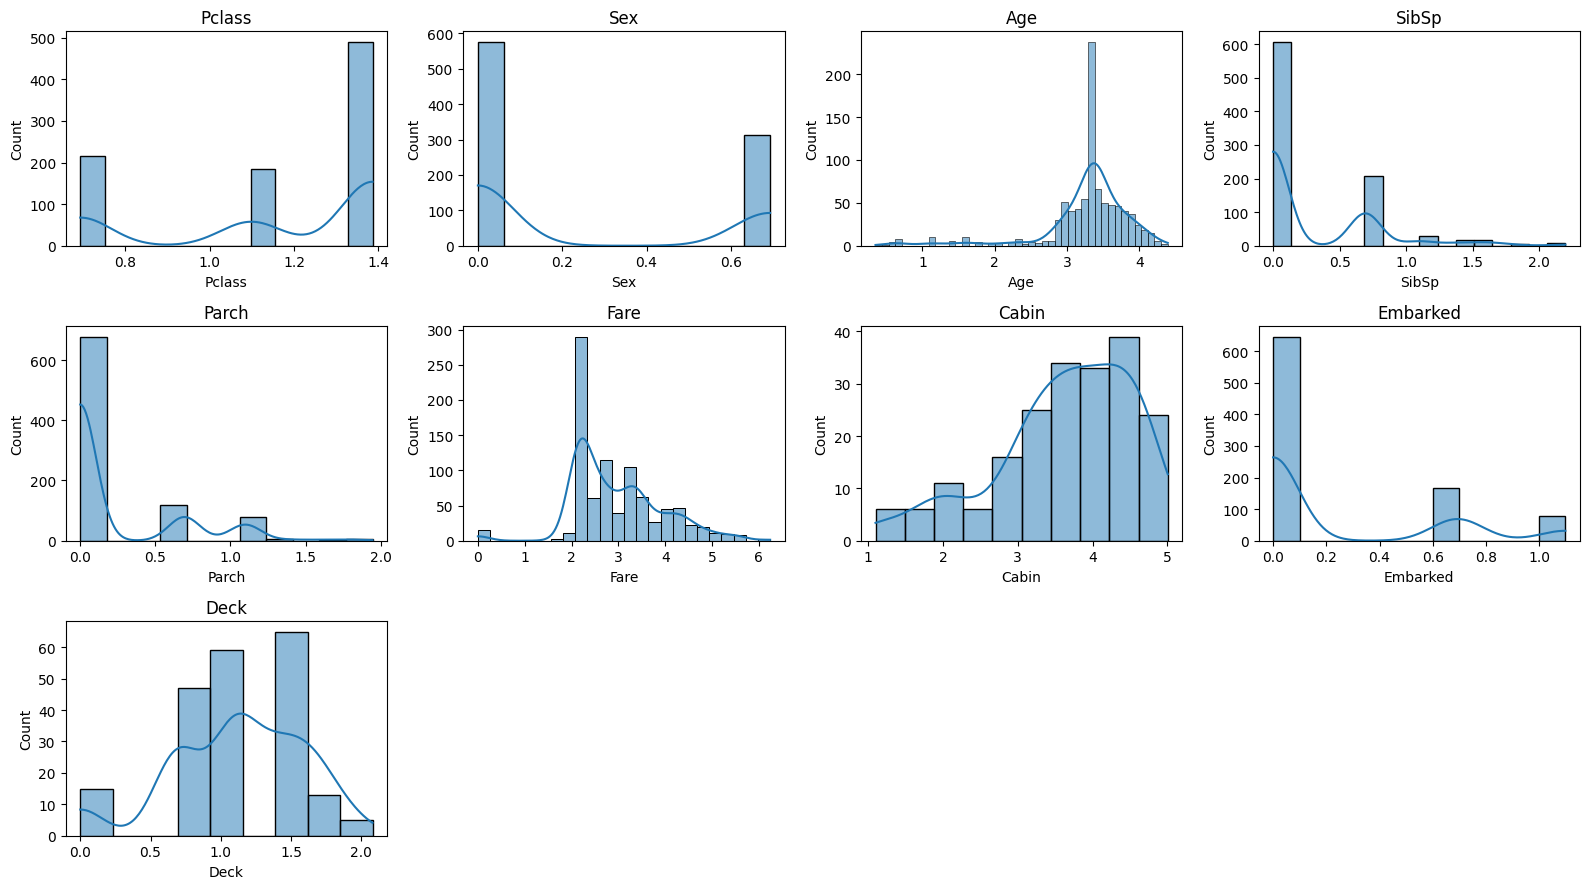

In [670]:
def prepare_skew(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

df_linear = prepare_skew(df = df_linear, columns = skew_columns_hard)

draw_skew(df_linear)

Сделаем `Feature Engineering` (3 штуки)

Определение 3. Feature Engineering - процесс добавления новых зависимостей признаков.

   * `FamilySize` - общий размер семьи на борту.
   * `IsAlone` - путешествовал ли пассажир один
   * `ClassFareInteraction` - взаимодействие класса и стоимости



In [671]:
# Полиномиальные признаки
if not USE_AUTO_POLY:
    
    df_linear['FamilySize'] = df_linear['SibSp'] + df_linear['Parch'] + 1
    df_linear['IsAlone'] = (df_linear['FamilySize'] == 1).astype(int)
    df_linear['ClassFareInteraction'] = df_linear['Pclass'] * df_linear['Fare']

else:
    from sklearn.preprocessing import PolynomialFeatures

    # Выбираем только числовые признаки для полиномиальных преобразований
    num_features = ['Pclass', 'Sex', 'Age',
                    'SibSp', 'Parch', 'Fare','Embarked']

    X_num = df_linear[num_features]

    # Создаём генератор полиномиальных признаков (degree=2)
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

    X_poly = poly.fit_transform(X_num)

    # Получаем имена новых признаков
    feature_names = poly.get_feature_names_out()

    # Превращаем обратно в DataFrame
    df_poly = pd.DataFrame(X_poly, columns=feature_names, index=df_linear.index)

    # Объединяем с исходным DataFrame (если нужно оставить остальные признаки)
    df_linear = pd.concat([df_linear, df_poly], axis=1)



In [672]:
if not USE_AUTO_POLY:
    draw_corr_matrix(df_linear)
else:
    print(df_linear.corr())

                 Survived    Pclass       Sex       Age     SibSp     Parch  \
Survived         1.000000 -0.334881  0.543351 -0.116024  0.029430  0.114999   
Pclass          -0.334881  1.000000 -0.128134 -0.248891  0.020515 -0.001170   
Sex              0.543351 -0.128134  1.000000 -0.078968  0.165302  0.256638   
Age             -0.116024 -0.248891 -0.078968  1.000000 -0.307664 -0.352963   
SibSp            0.029430  0.020515  0.165302 -0.307664  1.000000  0.473259   
Parch            0.114999 -0.001170  0.256638 -0.352963  0.473259  1.000000   
Fare             0.329862 -0.672499  0.263276  0.014458  0.375371  0.363261   
Cabin           -0.064628 -0.149861 -0.045753  0.243423 -0.063488 -0.135015   
Embarked         0.123181 -0.010067  0.119495  0.016087 -0.048330 -0.071766   
Deck             0.051028  0.490400  0.120695 -0.159428  0.090175  0.055474   
Pclass          -0.334881  1.000000 -0.128134 -0.248891  0.020515 -0.001170   
Sex              0.543351 -0.128134  1.000000 -0.078

In [673]:
if not USE_AUTO_POLY:
    draw_skew(df_linear, 5)

Разделение датасета на признаки и целевую переменную

In [674]:
from sklearn.model_selection import train_test_split

X_linear = df_linear.drop(columns=['Survived'])
y_linear = df_linear['Survived']

# Разделение выборки на test/train (20/80)
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=RND_SEED
)

#### отчистим бесконечности

In [675]:
for col in X_train_linear.columns:
    if np.any(np.isinf(X_train_linear[col])):
        print(f"Column '{col}' has infinite values")
        print(f"Min: {X_train_linear[col].min()}, Max: {X_train_linear[col].max()}")

# Clean ALL infinite values
X_train_linear = X_train_linear.replace([np.inf, -np.inf], np.nan)
X_test_linear = X_test_linear.replace([np.inf, -np.inf], np.nan)

# Fill with reasonable values
X_train_linear = X_train_linear.fillna(X_train_linear.median())
X_test_linear = X_test_linear.fillna(X_train_linear.median())

Column 'Cabin' has infinite values
Min: -inf, Max: 5.003946305945459
Column 'Deck' has infinite values
Min: -inf, Max: 2.0794415416798357


Данные для обучения модели нужно стандартизировать

***Определение 4: Стандартизация признаков — это метод преобразования числовых признаков так, чтобы они имели среднее значение 0 и стандартное отклонение 1. Это важный шаг в подготовке данных для моделей, чувствительных к масштабу признаков, например линейной регрессии, логистической регрессии, SVM, KNN.***

**Как это работает**

Для каждого признака $x$ вычисляется:

$$
x_\text{scaled} = \frac{x - \mu}{\sigma}
$$

где:

* $\mu$ — среднее значение признака в обучающей выборке,
* $\sigma$ — стандартное отклонение признака.

После стандартизации:

* Среднее значение нового признака ≈ 0
* Стандартное отклонение ≈ 1


In [676]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_linear_scaled = scaler.fit_transform(X_train_linear)  # вычисляет среднее и стандартное отклонение (только на train)
X_test_linear_scaled = scaler.transform(X_test_linear)  # применяет эти параметры к любым данным (train, test, новые данные)

#### 1.3.2 Random Forest Classifier

**Особенности модели:**

* Не чувствительна к масштабу признаков.
* Может обрабатывать сильные корреляции между признаками.
* Может использовать категориальные признаки, если они закодированы как числовые.


Сделаем копию датасета

In [677]:
df_forest = df.copy()

Feature engineering

In [678]:
df_forest['MotherWithChild'] = ((df_forest['Sex'] == 1) & (df_forest['Age'] > 18) & (df_forest['Parch'] > 0)).astype(int)
df_forest['WealthySingle'] = ((df_forest['Pclass'] == 1) & (df_forest['SibSp'] + df_forest['Parch'] == 0)).astype(int)
df_forest['ChildFirstClass'] = ((df_forest['Age'] < 18) & (df_forest['Pclass'] == 1)).astype(int)
df_forest['ChildThirdClass'] = ((df_forest['Age'] < 18) & (df_forest['Pclass'] == 3)).astype(int)

Разделение выборки

In [679]:
X_forest = df_forest.drop(columns=['Survived'])
y_forest = df_forest['Survived']

X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(
    X_forest, y_forest, test_size=0.2, random_state=RND_SEED
)

#### 1.3.3 XGBoost

**Особенности модели:**

* Градиентный бустинг деревьев.
* Не чувствителен к масштабу.
* Может обрабатывать коррелированные признаки, но слишком много слабых признаков может замедлить обучение.

Сделаем копию датасета

In [680]:
df_xgboost = df.copy()

Разделение выборки

In [681]:
X_xgboost = df_xgboost.drop(columns=['Survived'])
y_xgboost = df_xgboost['Survived']

X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(
    X_xgboost, y_xgboost, test_size=0.2, random_state=RND_SEED
)

## 2. Создание метрик

1. **MSE (Mean Squared Error)** – средняя квадратичная ошибка:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* Чем меньше, тем лучше.
* Чувствительна к выбросам (квадрат ошибки усиливает влияние больших отклонений).

2. **RMSE (Root Mean Squared Error)** – корень из MSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

* В тех же единицах, что и целевая переменная.
* Легче интерпретировать.

3. **MAE (Mean Absolute Error)** – средняя абсолютная ошибка:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* Менее чувствительна к выбросам, показывает «среднюю ошибку» в исходных единицах.

4. **R² (коэффициент детерминации)**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

* 1 → идеальное предсказание, 0 → модель не лучше среднего, <0 → хуже среднего.

**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

**Пример анализа:**

* Если RMSE и MAE сильно отличаются → есть выбросы.
* Если R² близок к 1 → модель хорошо объясняет вариацию данных.
* Можно сравнивать модели: линейная, RF, XGBoost. Та, у которой меньше RMSE/MAE и выше R² — более точная.


In [682]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }


Прежде чем начнем обучать, создадим `DataFrame` для снятия метрик

In [683]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_classification_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

def add_to_results(model_name, y_true, y_pred):
    global results_df
    metrics = get_classification_metrics(y_true, y_pred)
    results_df = pd.concat([results_df, pd.DataFrame([{
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'], 
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    }])], ignore_index=True)

## 3. Базовая модель логистической регрессии (аналитическое решение)

In [684]:
# Создание логист. модели
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=RND_SEED)

In [685]:
# Обучение
lr.fit(X_train_linear_scaled, y_train_linear)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,21
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [686]:
# Прогонка и метрики
from sklearn.metrics import classification_report

y_pred_lr = lr.predict(X_test_linear_scaled)
print(classification_report(y_test_linear, y_pred_lr))
add_to_results('Logistic Regression', y_test_linear, y_pred_lr)

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       105
           1       0.86      0.68      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.82      0.82       179



C:\Users\arty\AppData\Local\Temp\ipykernel_18188\3377496876.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{


## 4. Улучшенная версия логистической регрессии

In [687]:
from sklearn.linear_model import SGDClassifier

### 4.1. Градиентный спуск (симуляция)

In [688]:
# Создание линейной модели градиентного спуска
lr_gd = SGDClassifier(
    max_iter=2000,               # максимум итераций
    tol=1e-6,                    # остановка, когда улучшение < tol
    learning_rate='constant',  # тип изменения шага
    eta0=0.01,                   # стартовый шаг
    penalty='l2',                # регуляризация L2 (Ridge)
    shuffle=False,               # важный момент: не перемешиваем данные, чтобы был настоящий GD
    random_state=RND_SEED
)

In [689]:
# Обучение
lr_gd.fit(X_train_linear_scaled, y_train_linear)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,2000
,tol,1e-06
,shuffle,False
,verbose,0
,epsilon,0.1
,n_jobs,None


In [690]:
# Прогонка и метрики
y_pred = lr_gd.predict(X_test_linear_scaled)
lr_gd_metrics = get_classification_metrics(y_test_linear, y_pred)
lr_gd_metrics
add_to_results('SGD (GD)', y_test_linear, y_pred)

### 4.2. Стохастический градиентный спуск

In [691]:
# Инициализация модели
lr_sgd = SGDClassifier(
    max_iter=5000,                # максимум итераций
    tol=1e-6,                     # остановка, когда улучшение < tol
    learning_rate='invscaling',   # тип изменения шага
    eta0=0.01,                    # стартовый шаг
    penalty='l1',                 # регуляризация L2 (Ridge)
    random_state=RND_SEED
)

In [692]:
# Обучение
lr_sgd.fit(X_train_linear_scaled, y_train_linear)

,loss,'hinge'
,penalty,'l1'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,5000
,tol,1e-06
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [693]:
# Прогонка и метрики
y_pred = lr_sgd.predict(X_test_linear_scaled)
lr_sgd_metrics = get_classification_metrics(y_test_linear, y_pred)
lr_sgd_metrics
add_to_results('SGD (Stochastic)', y_test_linear, y_pred)

### 4.3. Линейная модель с регуляризацией Rigde (L2)

In [ ]:
# Инициализация модели
from sklearn.linear_model import RidgeClassifier
lr_ridge = RidgeClassifier(alpha=1.0, random_state=RND_SEED)

In [695]:
# Обучение
lr_ridge.fit(X_train_linear_scaled, y_train_linear)

,alpha,0.01
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,class_weight,None
,solver,'auto'
,positive,False
,random_state,21


In [696]:
# Прогонка и метрики
y_pred = lr_ridge.predict(X_test_linear_scaled)
lr_ridge_metrics = get_classification_metrics(y_test_linear, y_pred)
add_to_results('Ridge Classifier', y_test_linear, y_pred)
lr_ridge_metrics

{'Accuracy': 0.8268156424581006,
 'Precision': 0.864406779661017,
 'Recall': 0.6891891891891891,
 'F1-Score': 0.7669172932330827}

### 4.3. Линейная модель с регуляризацией Lasso (L1)

In [697]:
# Инициализация модели
from sklearn.linear_model import LogisticRegression
lr_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=RND_SEED)

In [698]:
# Обучение
lr_lasso.fit(X_train_linear_scaled, y_train_linear)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,21
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [699]:
# Прогонка и метрики
y_pred = lr_lasso.predict(X_test_linear_scaled)
lr_lasso_metrics = get_classification_metrics(y_test_linear, y_pred)
lr_lasso_metrics
add_to_results('Lasso Logistic', y_test_linear, y_pred)

### 4.4. Линейная модель с регуляризацией ElasticNet (комбинация L1+L2)

In [700]:
# Инициализация модели
from sklearn.linear_model import SGDClassifier
lr_enet = SGDClassifier(
    penalty='elasticnet',
    l1_ratio=0.5,
    alpha=0.01,
    random_state=RND_SEED
)

In [701]:
# Обучение
lr_enet.fit(X_train_linear_scaled, y_train_linear)

,loss,'hinge'
,penalty,'elasticnet'
,alpha,0.01
,l1_ratio,0.5
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [702]:
# Прогонка и метрики
y_pred = lr_enet.predict(X_test_linear_scaled)
lr_enet_metrics = get_classification_metrics(y_test_linear, y_pred)
lr_enet_metrics
add_to_results('ElasticNet', y_test_linear, y_pred)

## 4. Случайный лес классификатор

In [703]:
# Инициализация модели
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200,      # количество деревьев
    max_depth=None,        # глубина деревьев
    random_state=RND_SEED,
    n_jobs=-1              # использовать все ядра процессора
)

In [704]:
# Обучение
rf.fit(X_train_forest, y_train_forest)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [705]:
# Прогонка и метрики
y_pred = rf.predict(X_test_forest)
rf_metrics = get_classification_metrics(y_test_forest, y_pred)
rf_metrics
add_to_results('Random Forest', y_test_forest, y_pred)

## 5. Градиентный бустинг (XGBoost)

In [706]:
# Инициализация модели
import xgboost
xgb = xgboost.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND_SEED
)

In [707]:
# Обучение
xgb.fit(X_train_xgboost, y_train_xgboost)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [708]:
# Прогонка и метрики
y_pred = xgb.predict(X_test_xgboost)
xgb_metrics = get_classification_metrics(y_test_xgboost, y_pred)
xgb_metrics
add_to_results('XGBoost', y_test_xgboost, y_pred)

## 5. Feature Importance

### 5.1 Linear Regression


В **линейных моделях** (LinearRegression, Ridge, Lasso) **feature importance** — это не что иное, как **коэффициенты модели (`coef_`)**.

Но есть нюансы:

* Коэффициенты сами по себе могут быть несопоставимы по масштабу признаков.
* Поэтому мы правильно сделали **стандартизацию (StandardScaler)** → теперь коэффициенты отражают вклад признаков.
* Знак коэффициента (+ / -) показывает направление влияния:

  * `+` → признак увеличивает предсказание качества вина,
  * `-` → уменьшает.


C:\Users\arty\AppData\Local\Temp\ipykernel_18188\2762697988.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


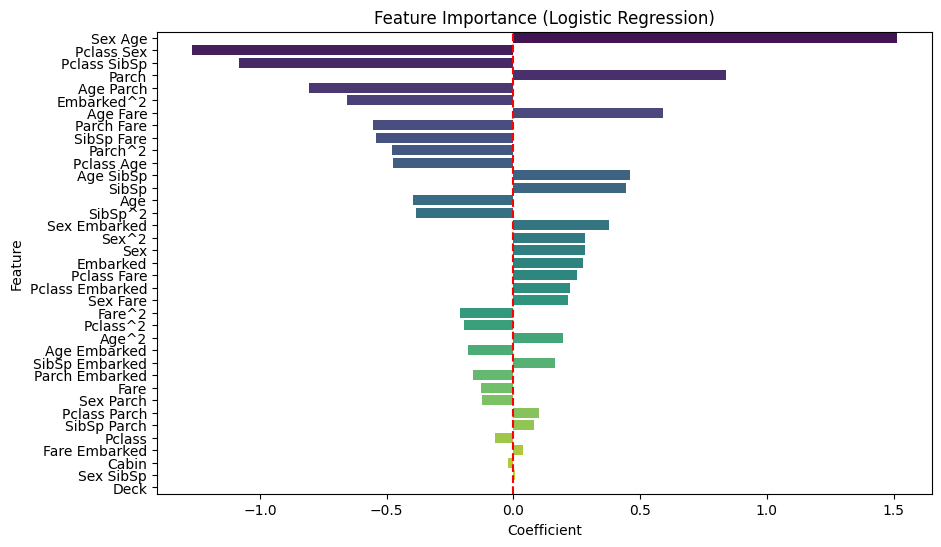

In [709]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

### 5.2 Linear Regression (GD)


C:\Users\arty\AppData\Local\Temp\ipykernel_18188\3988213811.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


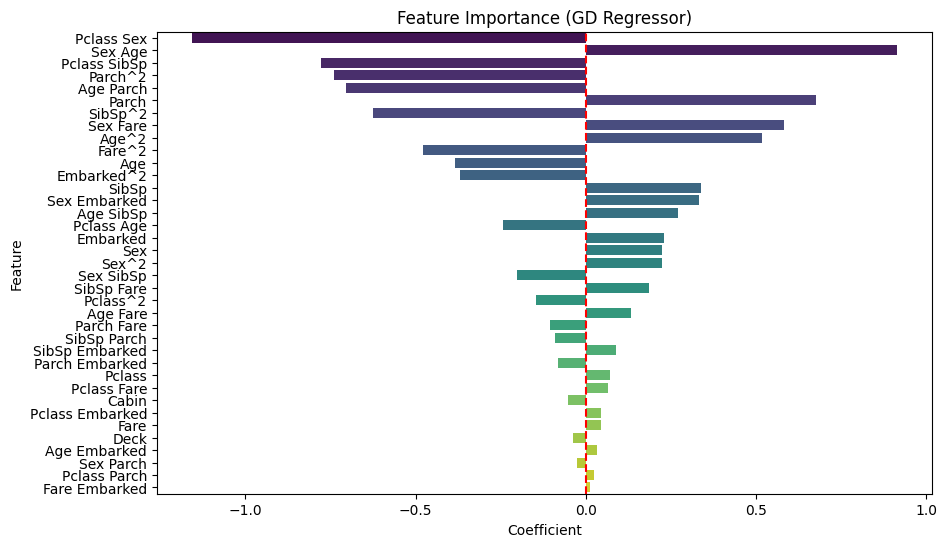

In [710]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_gd.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (GD Regressor)')
plt.show()

### 5.3 Linear Regression (SGD)


C:\Users\arty\AppData\Local\Temp\ipykernel_18188\1874231980.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


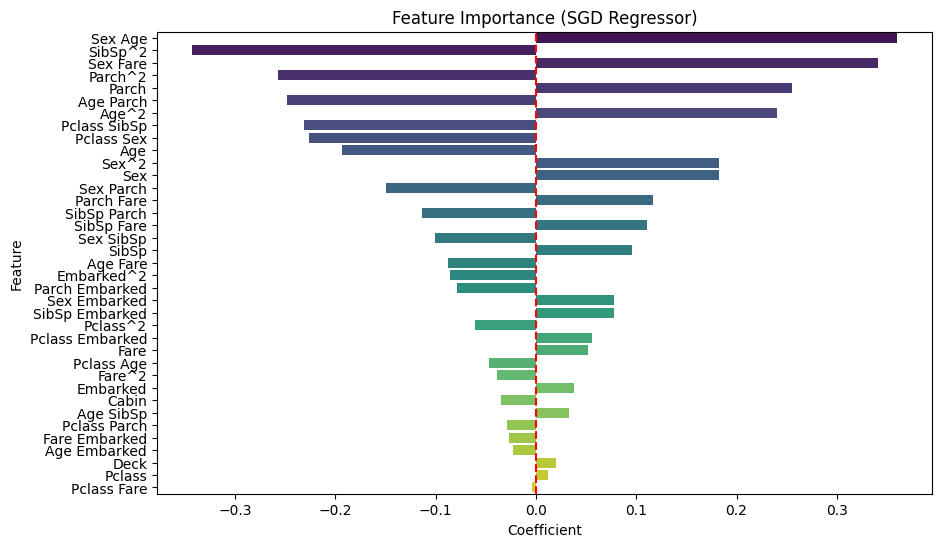

In [711]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_sgd.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (SGD Regressor)')
plt.show()

### 5.4 Linear Regression (Rigde)


C:\Users\arty\AppData\Local\Temp\ipykernel_18188\2681905751.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


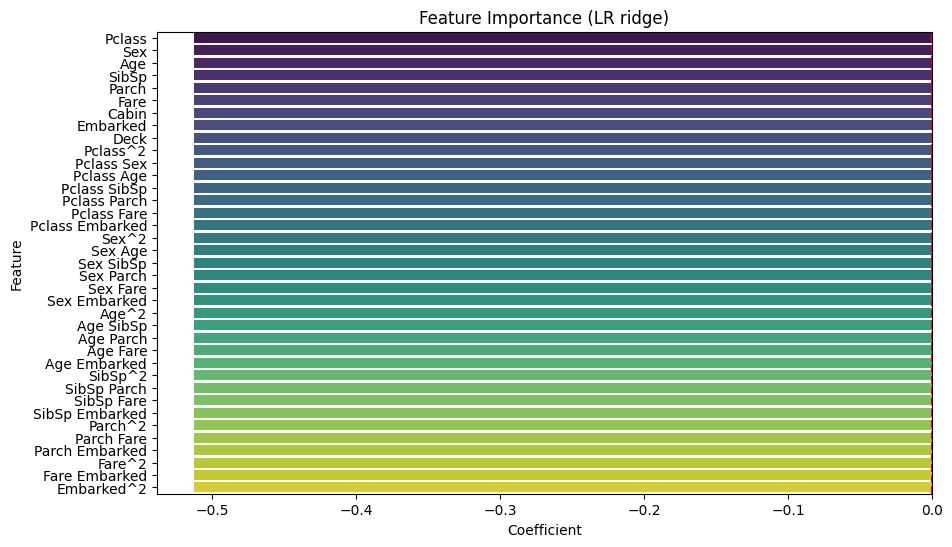

In [712]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_ridge.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR ridge)')
plt.show()

### 5.5 Linear Regression (Lasso)


C:\Users\arty\AppData\Local\Temp\ipykernel_18188\893265559.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


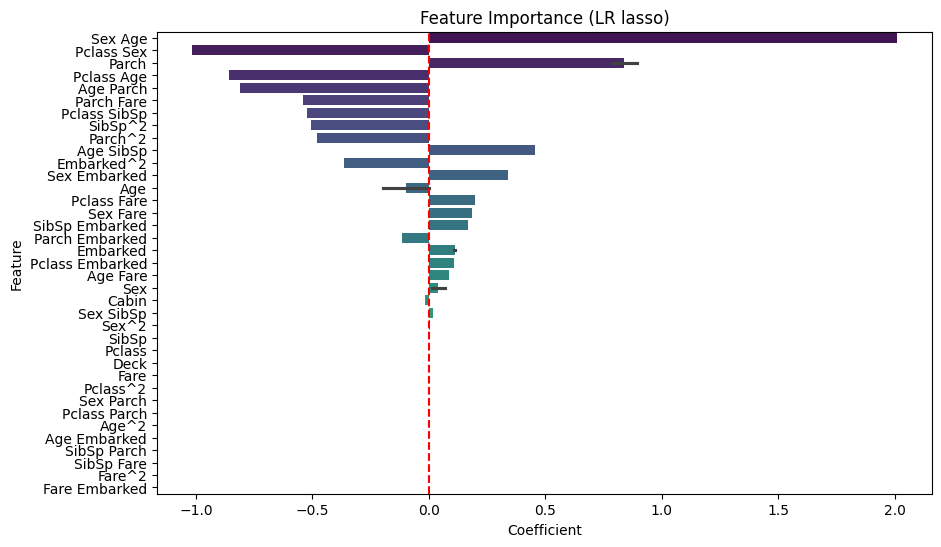

In [648]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_lasso.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR lasso)')
plt.show()

### 5.6 Linear Regression (ElasticNet)


C:\Users\arty\AppData\Local\Temp\ipykernel_18188\2312614949.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


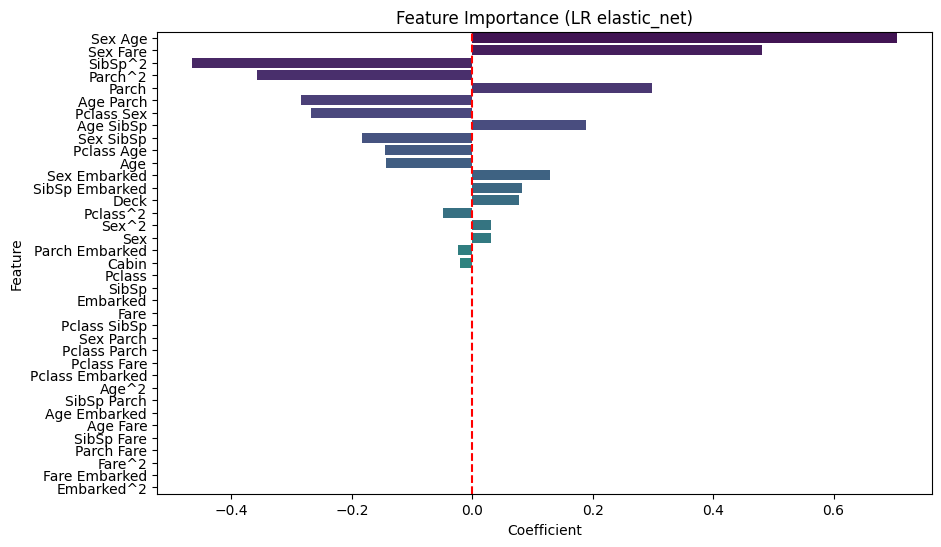

In [649]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_enet.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR elastic_net)')
plt.show()

### 5.7 Random Forest


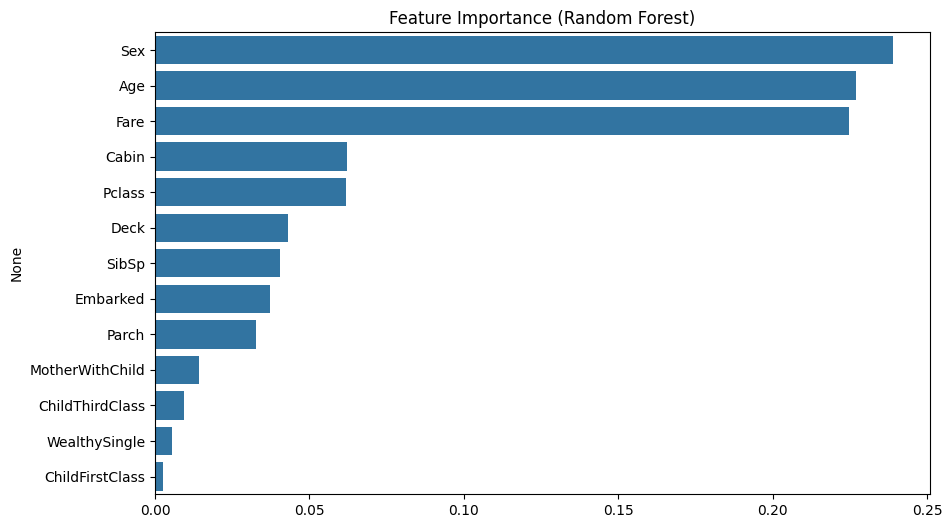

In [650]:
feature_importances = pd.Series(rf.feature_importances_, index=X_forest.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

### 5.6 XGBoost

<Figure size 1000x600 with 0 Axes>

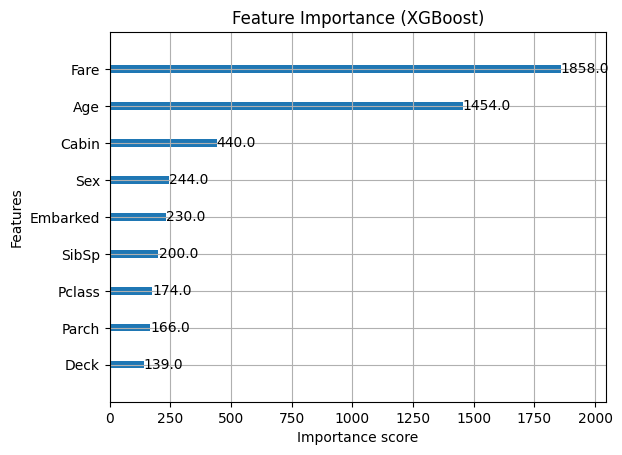

In [651]:
plt.figure(figsize=(10,6))
xgboost.plot_importance(xgb, importance_type='weight', max_num_features=10)
plt.title("Feature Importance (XGBoost)")
plt.show()

## 8. Написание своих реализаций (классы)

Напишите свои классы реализации:

- LR
- LR + GD
- LR + SGD
- *Random Forest (не обязательно)
- *Gradient Boosting Regressor (не обязательно)

In [655]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.lr = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, x):
        x = np.clip(x, -250, 250)
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for i in range(self.iterations):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(linear_pred)
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict_prob(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_pred)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_prob(X) >= threshold).astype(int)


class MyLogisticRegressionGD:

    def __init__(self, learning_rate=0.01, iterations=1000):
        self.lr = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for epoch in range(self.iterations):
            z = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(z)
            error = y_pred - y
            dw = np.dot(X.T, error) / n_samples
            db = np.sum(error) / n_samples
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict(self, X, threshold=0.5):
        z = np.dot(X, self.weights) + self.bias
        probabilities = self._sigmoid(z)
        return (probabilities >= threshold).astype(int)
    

class MyLogisticRegressionSGD:

    def __init__(self, learning_rate=0.01, iterations=1000, batch_size=32):
        self.lr = learning_rate
        self.iterations = iterations
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for epoch in range(self.iterations):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]
                if len(X_batch) == 0:
                    continue
                z_batch = np.dot(X_batch, self.weights) + self.bias
                y_pred_batch = self._sigmoid(z_batch)
                error_batch = y_pred_batch - y_batch
                dw_batch = np.dot(X_batch.T, error_batch) / len(X_batch)
                db_batch = np.sum(error_batch) / len(X_batch)
                self.weights -= self.lr * dw_batch
                self.bias -= self.lr * db_batch
    
    def predict(self, X, threshold=0.5):
        z = np.dot(X, self.weights) + self.bias
        probabilities = self._sigmoid(z)
        return (probabilities >= threshold).astype(int)

## 9. Итоги

Что сделать?

1. Сгрупировать все метрики, и выяснить, какой методо сработал лучше всего и почему?
2. Ответить на вопросы:

    1. Что такое регрессия и чем она отличается от классификации?
    2. Какова целевая переменная в задаче регрессии?
    3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?
    4. Что означает коэффициент признака в линейной регрессии?
    5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?
    6. В чем разница между Ridge и Lasso регуляризацией?
    7. Почему деревья решений и Random Forest не требуют стандартизации признаков?
    8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?
    9. Как можно уменьшить влияние выбросов на линейную регрессию?
    10. Какие гиперпараметры наиболее важны для Random Forest Regressor?
    11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?
    12. Что значит глубина дерева (max\_depth) и как она влияет на модель?
    13. Зачем нужен `learning_rate` в градиентном бустинге?
    14. Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?
    15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?
    16. Что такое переобучение и как его можно выявить на графике обучения?
    17. Как работает метод ансамблирования в Random Forest (bagging)?
    18. В чем отличие бустинга от бэггинга?
    19. Какие способы feature engineering можно применить к винному датасету (Titanic)?
    20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?


#### 9.1. Группировка метрик

In [653]:
print(results_df.sort_values('Accuracy', ascending=False))
best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nЛучшая модель: {best_model['Model']}")
print(f"Точность: {best_model['Accuracy']:.3f}")
print(f"F1-Score: {best_model['F1-Score']:.3f}")

                 Model  Accuracy  Precision    Recall  F1-Score
7              XGBoost  0.843575   0.848485  0.756757  0.800000
4       Lasso Logistic  0.832402   0.866667  0.702703  0.776119
3     Ridge Classifier  0.826816   0.864407  0.689189  0.766917
0  Logistic Regression  0.821229   0.862069  0.675676  0.757576
2     SGD (Stochastic)  0.815642   0.836066  0.689189  0.755556
1             SGD (GD)  0.815642   0.872727  0.648649  0.744186
6        Random Forest  0.815642   0.825397  0.702703  0.759124
5           ElasticNet  0.810056   0.822581  0.689189  0.750000

Лучшая модель: XGBoost
Точность: 0.844
F1-Score: 0.800


#### 9.2. Ответы на вопросы

Вопрос:

1. Что такое регрессия и чем она отличается от классификации?

Ответ:

Регрессия - предсказание непрерывной числовой величины (качество)

Классификация - предсказание категории/класса (выжил/не выжил)

Вопрос:

2. Какова целевая переменная в задаче классификации?

Ответ:

переменная, результат которой предсказывает программа, здесь: 'survived'

Вопрос:

3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?

Ответ:

Без масштабирования признаки с большими значениями (например Fare) будут доминировать над признаками с малыми значениями (например Age).

Вопрос:

4. Что означает коэффициент признака в линейной регрессии?

Ответ:

Насколько изменится целевая переменная при изменении признака на 1 единицу.

Вопрос:

5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?

Ответ:

MSE: Средняя квадратичная ошибка (чувствительна к выбросам)

RMSE: Корень из MSE (в оригинальных единицах)

MAE: Средняя абсолютная ошибка (устойчива к выбросам)

R²: Доля объясненной дисперсии (0-1, чем ближе к 1 тем лучше)

Вопрос:

6. В чем разница между Ridge и Lasso регуляризацией?

Ответ:

Lasso (L1): Может обнулять коэффициенты неважных признаков

Ridge (L2): Уменьшает все коэффициенты, но не обнуляет

Вопрос:

7. Почему деревья решений и Random Forest не требуют стандартизации признаков?

Ответ:

Деревья принимают решения на основе пороговых значений

Вопрос:

8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?

Ответ:

Мультиколлинеарность - сильная корреляция между признаками. Это обычно приводит к проблемам с интерпретацией вклада каждого индивидуального признака.

Вопрос:

9. Как можно уменьшить влияние выбросов на линейную регрессию?

Ответ:

Использовать MAE вместо MSE

Использовать регуляризацию (Ridge/Lasso)

Вопрос:

10. Какие гиперпараметры наиболее важны для Random Forest Regressor?

Ответ:

n_estimators: количество деревьев (больше = лучше, но медленнее)

max_depth: максимальная глубина деревьев

min_samples_split: минимальное количество samples для разделения узла

max_features: количество признаков для рассмотрения при разделении

Вопрос:

11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?

Ответ:

learning_rate: размер шага (меньше = точнее, но медленнее)

n_estimators: количество деревьев

max_depth: глубина деревьев

subsample: доля samples для обучения каждого дерева

colsample_bytree: доля признаков для каждого дерева

Вопрос:

12. Что значит глубина дерева (max_depth) и как она влияет на модель?

Ответ:

Глубина дерева - максимальное количество решений от корня до листа.

Малая глубина: простая модель, может недообучаться

Большая глубина: сложная модель, может переобучаться

Вопрос:

13. Зачем нужен `learning_rate` в градиентном бустинге?

Ответ:

learning_rate контролирует размер шага при обновлении предсказаний:

Малый LR: медленное, точное обучение, требует больше работы

Большой: быстрое обучение, риск перескакивания

Вопрос:

14. Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?

Ответ:

Линейная регрессия: абсолютные значения коэффициентов (после стандартизации)

Random Forest: feature_importances_ (на основе уменьшения impurity)

XGBoost: plot_importance (weight, gain, или cover)

Вопрос:

15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?

Ответ:

деревья учатся на ошибках предыдущих

встроенная защита от переобучения

Вопрос:

16. Что такое переобучение и как его можно выявить на графике обучения?

Ответ:

Переобучение - когда модель запоминает шум вместо общих закономерностей.
Признаки:

Высокий train accuracy, низкий test accuracy

Большая разница между train и test ошибками

Вопрос:

17. Как работает метод ансамблирования в Random Forest (bagging)?

Ответ:

Создаются множественные деревья на случайных подвыборках данных

Каждое дерево обучается на случайном подмножестве признаков

Итоговый прогноз - усреднение предсказаний всех деревьев

Вопрос:

18. В чем отличие бустинга от бэггинга?

Ответ:

Bagging: параллельное обучение независимых моделей, усреднение

Boosting: последовательное обучение, каждое дерево исправляет ошибки предыдущего

Вопрос:

19. Какие способы feature engineering можно применить к винному датасету (Titanic)?

Ответ:

Можно извлечь из имен титулы людей, что укажет на их социальный статус

также можно использовать SibSp и Parch для выявления семейных обстоятельств людей

эти два фактора вместе могли бы указать на приоритет спасения (женщины высшего класса раньше/одинокие мужчины низшего класса позже)

Вопрос:

20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?

Ответ:

Создаем словарь со всеми возможными значениями гиперпараметров для перебора

Данные разбиваются на K фолдов (обычно 5 или 10), модель обучается на K-1 фолдах и валидируется на оставшемся

Для каждой комбинации параметров вычисляется средняя метрика по всем фолдам

Выбирается комбинация с наилучшим средним результатом